In [1]:
import argparse, json, os
from imageio import imwrite
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
import sys
import cv2

sys.path.append("./sg2im")

from sg2im.model import Sg2ImModel
from sg2im.data.utils import imagenet_deprocess_batch
import sg2im.vis as vis

/home/ffundel/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ffundel/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
if not torch.cuda.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('cuda:0')

In [3]:
# Load the model, with a bit of care in case there are no GPUs
map_location = 'cpu' if device == torch.device('cpu') else None
checkpoint = torch.load("sg2im/sg2im-models/coco64.pt", map_location=map_location)
model = Sg2ImModel(**checkpoint['model_kwargs'])
model.load_state_dict(checkpoint['model_state'])
model.eval()
model.to(device)

Sg2ImModel(
  (obj_embeddings): Embedding(185, 128)
  (pred_embeddings): Embedding(11, 128)
  (gconv): GraphTripleConv(
    (net1): Sequential(
      (0): Linear(in_features=384, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1152, bias=True)
      (3): ReLU()
    )
    (net2): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=128, bias=True)
      (3): ReLU()
    )
  )
  (gconv_net): GraphTripleConvNet(
    (gconvs): ModuleList(
      (0): GraphTripleConv(
        (net1): Sequential(
          (0): Linear(in_features=384, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=1152, bias=True)
          (3): ReLU()
        )
        (net2): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias

In [4]:
# Load the scene graphs
with open('sg2im/scene_graphs/examples.json', 'r') as f:
    scene_graphs = json.load(f)

# Run the model forward
with torch.no_grad():
    objs, triples, obj_to_img = model.encode_scene_graphs(scene_graphs)
    imgs, boxes_pred, masks_pred, rel_scores, layout = model.forward(objs, triples, obj_to_img)

/home/ffundel/.local/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/ffundel/.local/lib/python3.8/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [5]:
print(len(objs), objs)
print(model.vocab['object_idx_to_name'][129])
print(len(model.vocab['object_idx_to_name']))

68 tensor([  6, 157, 169, 149,   0,   1,   1,  39, 145,   1, 169, 173,  99,   0,
        125, 147,   7, 157, 169, 111,   0,   9, 150, 135, 157, 155,   0, 158,
        155, 106,  95,  96,   9,   9,   0,  19, 169,  19, 124,  19, 157,   0,
          3,  96, 166, 181, 140, 120, 149,   0,  22, 124,  97, 169,   0, 159,
        169,  94,   1,   0, 140,   3,  96, 149, 172, 157, 132,   0],
       device='cuda:0')
leaves
184


In [6]:
import numpy as np

unique_indices, counts = np.unique(obj_to_img.cpu().numpy(), return_counts=True)
grouped_boxes = np.split(boxes_pred.cpu().numpy(), np.cumsum(counts)[:-1])
grouped_objs = np.split(objs.cpu().numpy(), np.cumsum(counts)[:-1])
grouped_masks = np.split(layout.cpu().numpy(), np.cumsum(counts)[:-1])

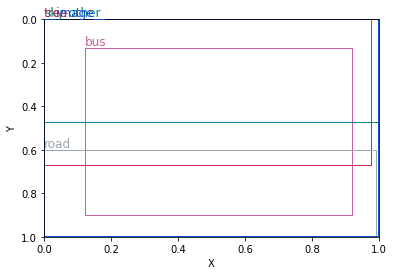

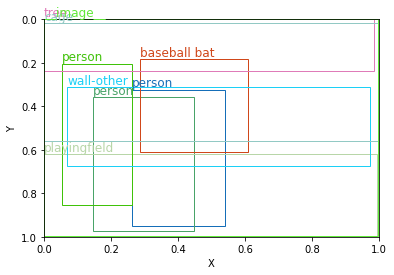

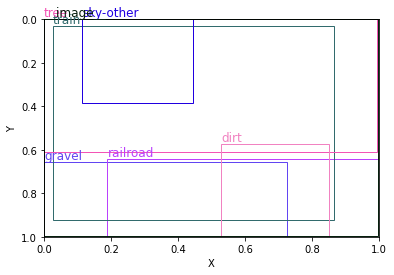

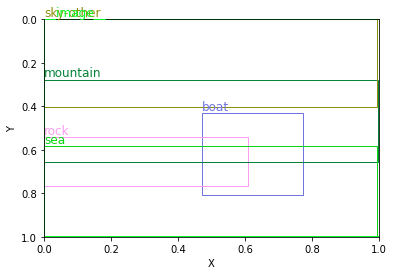

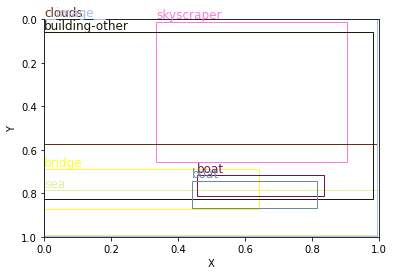

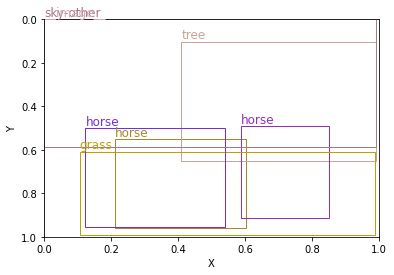

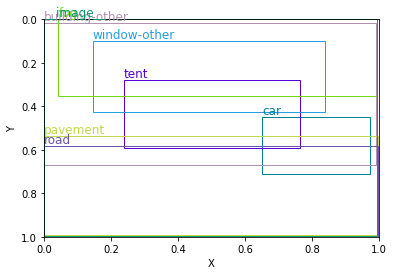

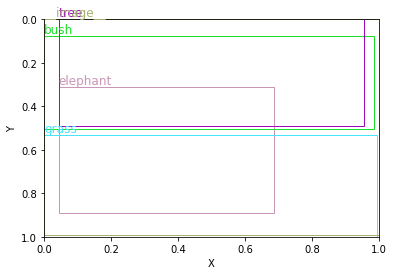

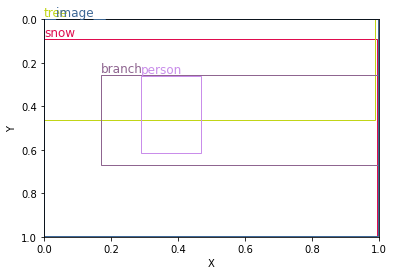

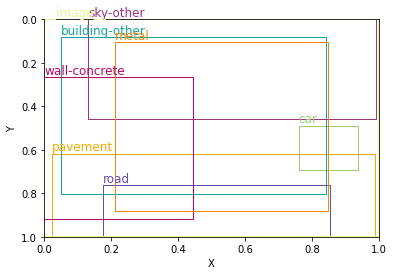

In [7]:
import matplotlib.patches as patches
import random

# Plot the rectangles
for g, group in enumerate(grouped_boxes):
    fig, ax = plt.subplots()
    for box, obj in zip(group, grouped_objs[g]):
        color = (random.random(), random.random(), random.random())
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                 linewidth=1, edgecolor=color,
                                 facecolor='none')
        ax.text(box[0], box[1]-0.06, model.vocab['object_idx_to_name'][obj], fontsize=12, va='top', color=color)
        ax.add_patch(rect)

    # Set plot limits
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    # Flip the plot upside down
    ax.invert_yaxis()

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Show the plot
    plt.show()
    img_path = os.path.join('box_images', 'box%06d.png' % g)
    fig.savefig(img_path)

In [33]:
COCO_CATEGORIES = [
    {"color": [220, 20, 60], "isthing": 1, "id": 1, "name": "person"},
    {"color": [119, 11, 32], "isthing": 1, "id": 2, "name": "bicycle"},
    {"color": [0, 0, 142], "isthing": 1, "id": 3, "name": "car"},
    {"color": [0, 0, 230], "isthing": 1, "id": 4, "name": "motorcycle"},
    {"color": [106, 0, 228], "isthing": 1, "id": 5, "name": "airplane"},
    {"color": [0, 60, 100], "isthing": 1, "id": 6, "name": "bus"},
    {"color": [0, 80, 100], "isthing": 1, "id": 7, "name": "train"},
    {"color": [0, 0, 70], "isthing": 1, "id": 8, "name": "truck"},
    {"color": [0, 0, 192], "isthing": 1, "id": 9, "name": "boat"},
    {"color": [250, 170, 30], "isthing": 1, "id": 10, "name": "traffic light"},
    {"color": [100, 170, 30], "isthing": 1, "id": 11, "name": "fire hydrant"},
    {"color": [220, 220, 0], "isthing": 1, "id": 13, "name": "stop sign"},
    {"color": [175, 116, 175], "isthing": 1, "id": 14, "name": "parking meter"},
    {"color": [250, 0, 30], "isthing": 1, "id": 15, "name": "bench"},
    {"color": [165, 42, 42], "isthing": 1, "id": 16, "name": "bird"},
    {"color": [255, 77, 255], "isthing": 1, "id": 17, "name": "cat"},
    {"color": [0, 226, 252], "isthing": 1, "id": 18, "name": "dog"},
    {"color": [182, 182, 255], "isthing": 1, "id": 19, "name": "horse"},
    {"color": [0, 82, 0], "isthing": 1, "id": 20, "name": "sheep"},
    {"color": [120, 166, 157], "isthing": 1, "id": 21, "name": "cow"},
    {"color": [110, 76, 0], "isthing": 1, "id": 22, "name": "elephant"},
    {"color": [174, 57, 255], "isthing": 1, "id": 23, "name": "bear"},
    {"color": [199, 100, 0], "isthing": 1, "id": 24, "name": "zebra"},
    {"color": [72, 0, 118], "isthing": 1, "id": 25, "name": "giraffe"},
    {"color": [255, 179, 240], "isthing": 1, "id": 27, "name": "backpack"},
    {"color": [0, 125, 92], "isthing": 1, "id": 28, "name": "umbrella"},
    {"color": [209, 0, 151], "isthing": 1, "id": 31, "name": "handbag"},
    {"color": [188, 208, 182], "isthing": 1, "id": 32, "name": "tie"},
    {"color": [0, 220, 176], "isthing": 1, "id": 33, "name": "suitcase"},
    {"color": [255, 99, 164], "isthing": 1, "id": 34, "name": "frisbee"},
    {"color": [92, 0, 73], "isthing": 1, "id": 35, "name": "skis"},
    {"color": [133, 129, 255], "isthing": 1, "id": 36, "name": "snowboard"},
    {"color": [78, 180, 255], "isthing": 1, "id": 37, "name": "sports ball"},
    {"color": [0, 228, 0], "isthing": 1, "id": 38, "name": "kite"},
    {"color": [174, 255, 243], "isthing": 1, "id": 39, "name": "baseball bat"},
    {"color": [45, 89, 255], "isthing": 1, "id": 40, "name": "baseball glove"},
    {"color": [134, 134, 103], "isthing": 1, "id": 41, "name": "skateboard"},
    {"color": [145, 148, 174], "isthing": 1, "id": 42, "name": "surfboard"},
    {"color": [255, 208, 186], "isthing": 1, "id": 43, "name": "tennis racket"},
    {"color": [197, 226, 255], "isthing": 1, "id": 44, "name": "bottle"},
    {"color": [171, 134, 1], "isthing": 1, "id": 46, "name": "wine glass"},
    {"color": [109, 63, 54], "isthing": 1, "id": 47, "name": "cup"},
    {"color": [207, 138, 255], "isthing": 1, "id": 48, "name": "fork"},
    {"color": [151, 0, 95], "isthing": 1, "id": 49, "name": "knife"},
    {"color": [9, 80, 61], "isthing": 1, "id": 50, "name": "spoon"},
    {"color": [84, 105, 51], "isthing": 1, "id": 51, "name": "bowl"},
    {"color": [74, 65, 105], "isthing": 1, "id": 52, "name": "banana"},
    {"color": [166, 196, 102], "isthing": 1, "id": 53, "name": "apple"},
    {"color": [208, 195, 210], "isthing": 1, "id": 54, "name": "sandwich"},
    {"color": [255, 109, 65], "isthing": 1, "id": 55, "name": "orange"},
    {"color": [0, 143, 149], "isthing": 1, "id": 56, "name": "broccoli"},
    {"color": [179, 0, 194], "isthing": 1, "id": 57, "name": "carrot"},
    {"color": [209, 99, 106], "isthing": 1, "id": 58, "name": "hot dog"},
    {"color": [5, 121, 0], "isthing": 1, "id": 59, "name": "pizza"},
    {"color": [227, 255, 205], "isthing": 1, "id": 60, "name": "donut"},
    {"color": [147, 186, 208], "isthing": 1, "id": 61, "name": "cake"},
    {"color": [153, 69, 1], "isthing": 1, "id": 62, "name": "chair"},
    {"color": [3, 95, 161], "isthing": 1, "id": 63, "name": "couch"},
    {"color": [163, 255, 0], "isthing": 1, "id": 64, "name": "potted plant"},
    {"color": [119, 0, 170], "isthing": 1, "id": 65, "name": "bed"},
    {"color": [0, 182, 199], "isthing": 1, "id": 67, "name": "dining table"},
    {"color": [0, 165, 120], "isthing": 1, "id": 70, "name": "toilet"},
    {"color": [183, 130, 88], "isthing": 1, "id": 72, "name": "tv"},
    {"color": [95, 32, 0], "isthing": 1, "id": 73, "name": "laptop"},
    {"color": [130, 114, 135], "isthing": 1, "id": 74, "name": "mouse"},
    {"color": [110, 129, 133], "isthing": 1, "id": 75, "name": "remote"},
    {"color": [166, 74, 118], "isthing": 1, "id": 76, "name": "keyboard"},
    {"color": [219, 142, 185], "isthing": 1, "id": 77, "name": "cell phone"},
    {"color": [79, 210, 114], "isthing": 1, "id": 78, "name": "microwave"},
    {"color": [178, 90, 62], "isthing": 1, "id": 79, "name": "oven"},
    {"color": [65, 70, 15], "isthing": 1, "id": 80, "name": "toaster"},
    {"color": [127, 167, 115], "isthing": 1, "id": 81, "name": "sink"},
    {"color": [59, 105, 106], "isthing": 1, "id": 82, "name": "refrigerator"},
    {"color": [142, 108, 45], "isthing": 1, "id": 84, "name": "book"},
    {"color": [196, 172, 0], "isthing": 1, "id": 85, "name": "clock"},
    {"color": [95, 54, 80], "isthing": 1, "id": 86, "name": "vase"},
    {"color": [128, 76, 255], "isthing": 1, "id": 87, "name": "scissors"},
    {"color": [201, 57, 1], "isthing": 1, "id": 88, "name": "teddy bear"},
    {"color": [246, 0, 122], "isthing": 1, "id": 89, "name": "hair drier"},
    {"color": [191, 162, 208], "isthing": 1, "id": 90, "name": "toothbrush"},
    {"color": [255, 255, 128], "isthing": 0, "id": 92, "name": "banner"},
    {"color": [147, 211, 203], "isthing": 0, "id": 93, "name": "blanket"},
    {"color": [150, 100, 100], "isthing": 0, "id": 95, "name": "bridge"},
    {"color": [168, 171, 172], "isthing": 0, "id": 100, "name": "cardboard"},
    {"color": [146, 112, 198], "isthing": 0, "id": 107, "name": "counter"},
    {"color": [210, 170, 100], "isthing": 0, "id": 109, "name": "curtain"},
    {"color": [92, 136, 89], "isthing": 0, "id": 112, "name": "door-stuff"},
    {"color": [218, 88, 184], "isthing": 0, "id": 118, "name": "floor-wood"},
    {"color": [241, 129, 0], "isthing": 0, "id": 119, "name": "flower"},
    {"color": [217, 17, 255], "isthing": 0, "id": 122, "name": "fruit"},
    {"color": [124, 74, 181], "isthing": 0, "id": 125, "name": "gravel"},
    {"color": [70, 70, 70], "isthing": 0, "id": 128, "name": "house"},
    {"color": [255, 228, 255], "isthing": 0, "id": 130, "name": "light"},
    {"color": [154, 208, 0], "isthing": 0, "id": 133, "name": "mirror-stuff"},
    {"color": [193, 0, 92], "isthing": 0, "id": 138, "name": "net"},
    {"color": [76, 91, 113], "isthing": 0, "id": 141, "name": "pillow"},
    {"color": [255, 180, 195], "isthing": 0, "id": 144, "name": "platform"},
    {"color": [106, 154, 176], "isthing": 0, "id": 145, "name": "playingfield"},
    {"color": [230, 150, 140], "isthing": 0, "id": 147, "name": "railroad"},
    {"color": [60, 143, 255], "isthing": 0, "id": 148, "name": "river"},
    {"color": [128, 64, 128], "isthing": 0, "id": 149, "name": "road"},
    {"color": [92, 82, 55], "isthing": 0, "id": 151, "name": "roof"},
    {"color": [254, 212, 124], "isthing": 0, "id": 154, "name": "sand"},
    {"color": [73, 77, 174], "isthing": 0, "id": 155, "name": "sea"},
    {"color": [255, 160, 98], "isthing": 0, "id": 156, "name": "shelf"},
    {"color": [255, 255, 255], "isthing": 0, "id": 159, "name": "snow"},
    {"color": [104, 84, 109], "isthing": 0, "id": 161, "name": "stairs"},
    {"color": [169, 164, 131], "isthing": 0, "id": 166, "name": "tent"},
    {"color": [225, 199, 255], "isthing": 0, "id": 168, "name": "towel"},
    {"color": [137, 54, 74], "isthing": 0, "id": 171, "name": "wall-brick"},
    {"color": [135, 158, 223], "isthing": 0, "id": 175, "name": "wall-stone"},
    {"color": [7, 246, 231], "isthing": 0, "id": 176, "name": "wall-tile"},
    {"color": [107, 255, 200], "isthing": 0, "id": 177, "name": "wall-wood"},
    {"color": [58, 41, 149], "isthing": 0, "id": 178, "name": "water-other"},
    {"color": [183, 121, 142], "isthing": 0, "id": 180, "name": "window-blind"},
    {"color": [255, 73, 97], "isthing": 0, "id": 181, "name": "window-other"},
    {"color": [107, 142, 35], "isthing": 0, "id": 184, "name": "tree"},
    {"color": [190, 153, 153], "isthing": 0, "id": 185, "name": "fence"},
    {"color": [146, 139, 141], "isthing": 0, "id": 186, "name": "ceiling-other"},
    {"color": [70, 130, 180], "isthing": 0, "id": 187, "name": "sky-other"},
    {"color": [134, 199, 156], "isthing": 0, "id": 188, "name": "cabinet"},
    {"color": [209, 226, 140], "isthing": 0, "id": 189, "name": "table"},
    {"color": [96, 36, 108], "isthing": 0, "id": 190, "name": "floor-other"},
    {"color": [96, 96, 96], "isthing": 0, "id": 191, "name": "pavement"},
    {"color": [64, 170, 64], "isthing": 0, "id": 192, "name": "mountain"},
    {"color": [152, 251, 152], "isthing": 0, "id": 193, "name": "grass"},
    {"color": [208, 229, 228], "isthing": 0, "id": 194, "name": "dirt"},
    {"color": [206, 186, 171], "isthing": 0, "id": 195, "name": "paper"},
    {"color": [152, 161, 64], "isthing": 0, "id": 196, "name": "food-other"},
    {"color": [116, 112, 0], "isthing": 0, "id": 197, "name": "building-other"},
    {"color": [0, 114, 143], "isthing": 0, "id": 198, "name": "rock"},
    {"color": [102, 102, 156], "isthing": 0, "id": 199, "name": "wall-other"},
    {"color": [250, 141, 255], "isthing": 0, "id": 200, "name": "rug"},
]

mapping = {
  "street sign": "stop sign",
  "hat": "person",
  "shoe": "person",
  "eye glasses": "window-other",
  "plate": "dining table",
  "mirror": "mirror-stuff",
  "window": "window-other",
  "desk": "table",
  "door": "door-stuff",
  "blender": "microwave",
  "hair brush": "hair drier",
  "branch": "tree",
  "bush": "tree",
  "cage": "fence",
  "carpet": "rug",
  "ceiling-tile": "ceiling-other",
  "cloth": "rug",
  "clothes": "rug",
  "clouds": "sky-other",
  "cupboard": "cabinet",
  "desk-stuff": "table",
  "floor-marble": "floor-other",
  "floor-stone": "floor-other",
  "floor-tile": "floor-other",
  "furniture-other": "chair",
  "ground-other": "pavement",
  "hill": "mountain",
  "leaves": "tree",
  "mat": "rug",
  "metal": "wall-other",
  "moss": "tree",
  "mud": "dirt",
  "plant-other": "potted plant",
  "salad": "bowl",
  "skyscraper": "building-other",
  "stone": "rock",
  "textile-other": "rug",
  "vegetable": "broccoli",
  "wall-concrete": "wall-other",
  "wall-panel": "wall-tile",
  "waterdrops": "water-other",
  "wood": "floor-wood"
}


colors = {}
colors_names = {}
for o in COCO_CATEGORIES:
    name = o['name']
    color = o['color']
    if name in model.vocab['object_name_to_idx']:
        idx = model.vocab['object_name_to_idx'][name]
        colors[idx] = color
    colors_names[name] = color
        
for key in mapping:
    name = mapping[key]
    color = colors_names[name]
    if key in model.vocab['object_name_to_idx']:
        idx = model.vocab['object_name_to_idx'][key]
        colors[idx] = color
        print(key, color)
    else:
        print(name)

stop sign
person
person
window-other
dining table
mirror-stuff
window-other
table
door-stuff
microwave
hair drier
branch [107, 142, 35]
bush [107, 142, 35]
cage [190, 153, 153]
carpet [250, 141, 255]
ceiling-tile [146, 139, 141]
cloth [250, 141, 255]
clothes [250, 141, 255]
clouds [70, 130, 180]
cupboard [134, 199, 156]
desk-stuff [209, 226, 140]
floor-marble [96, 36, 108]
floor-stone [96, 36, 108]
floor-tile [96, 36, 108]
furniture-other [153, 69, 1]
ground-other [96, 96, 96]
hill [64, 170, 64]
leaves [107, 142, 35]
mat [250, 141, 255]
metal [102, 102, 156]
moss [107, 142, 35]
mud [208, 229, 228]
plant-other [163, 255, 0]
salad [84, 105, 51]
skyscraper [116, 112, 0]
stone [0, 114, 143]
textile-other [250, 141, 255]
vegetable [0, 143, 149]
wall-concrete [102, 102, 156]
wall-panel [7, 246, 231]
waterdrops [58, 41, 149]
wood [218, 88, 184]


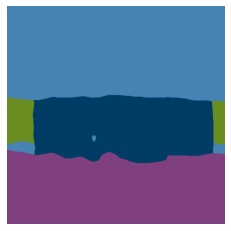

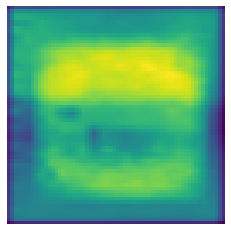

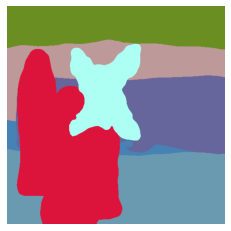

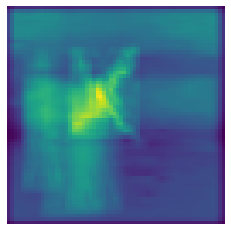

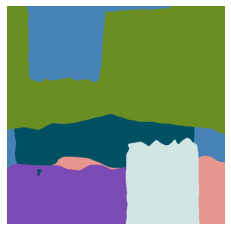

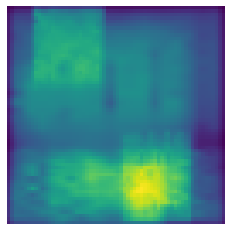

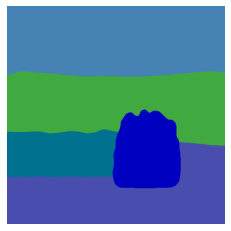

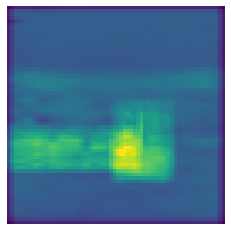

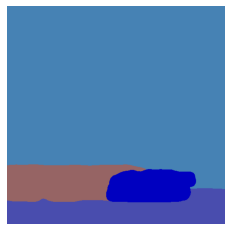

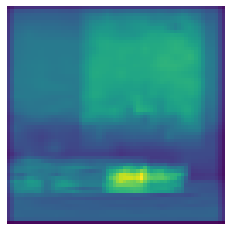

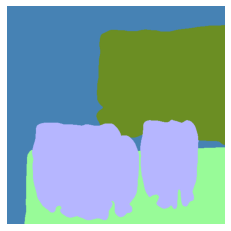

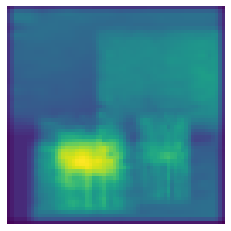

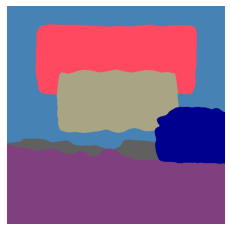

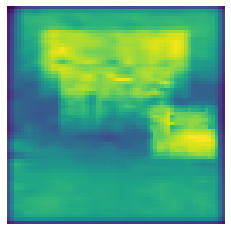

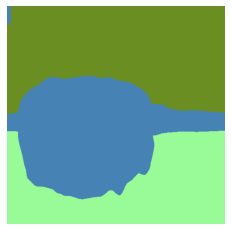

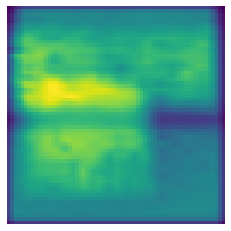

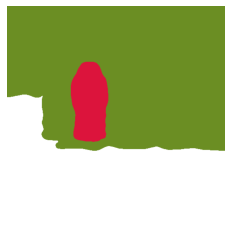

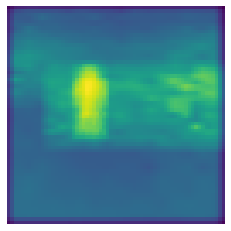

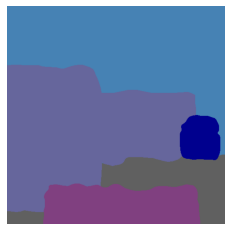

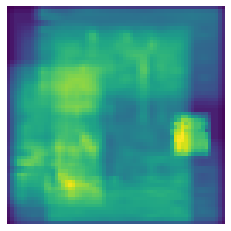

In [34]:
for g, group in enumerate(grouped_masks):
    semantic_map = np.zeros((512, 512))
    components = []
    areas = []
    summed_mask = np.zeros((64, 64))
    for i, mask in enumerate(group):
        obj = grouped_objs[g][i]
        obj_name = model.vocab['object_idx_to_name'][obj]
        mask = mask.sum(0)
        summed_mask += mask
        if not obj_name == '__image__':
            cv2_image = np.expand_dims(mask, 2).astype("uint8")
            cv2_image = cv2_image[2:61, 2:61]
            cv2_image = cv2.resize(cv2_image, (512, 512))
            cv2_image = cv2.medianBlur(cv2_image, 7)
            _, thresholded = cv2.threshold(cv2_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            _, labels, stats, _ = cv2.connectedComponentsWithStats(thresholded)
            area = stats[:, cv2.CC_STAT_AREA][1]
            components.append(labels * obj)
            areas.append(-area)
    sort_idcs = np.argsort(areas)
    for i in sort_idcs:
        img = components[i]
        nonz = np.nonzero(img)
        semantic_map[nonz] = img[nonz]
    
    color_seg = np.zeros((512, 512, 3), dtype=np.uint8)
    for idx in colors:
        color_seg[semantic_map == idx, :] = colors[idx]
        
    #color_seg[color_seg[:, :, 2] == 0] = [70, 130, 180] #sky
    
    color_seg = color_seg.astype(np.uint8)
    plt.imshow(color_seg)
    plt.axis('off')
    plt.show()
    img_path = os.path.join('semantic_maps', 'img' + str(g) + '.png')
    matplotlib.image.imsave(img_path, color_seg)
    
    plt.imshow(summed_mask)
    plt.axis('off')
    plt.show()
    img_path = os.path.join('summed_masks', 'img' + str(g) + '.png')
    matplotlib.image.imsave(img_path, summed_mask)

In [10]:
# Export in GLIGEN friendly format

import json

data = []
for g, group in enumerate(grouped_boxes):
    rects = []
    labels = []
    for box, obj in zip(group, grouped_objs[g]):
        rect = [float(box[0]), float(box[1]), float(box[2]-box[0]), float(box[3]-box[1])]
        label = model.vocab['object_idx_to_name'][obj]
        rects.append(rect)
        labels.append(label)
    data.append([rects, labels])
    
with open('data.json', 'w') as f:
    json.dump(data, f)

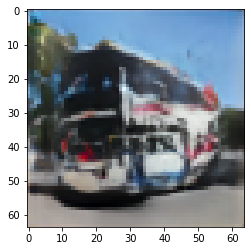

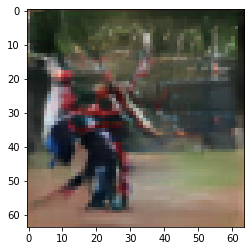

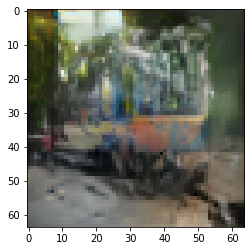

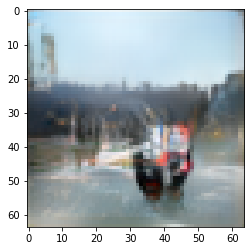

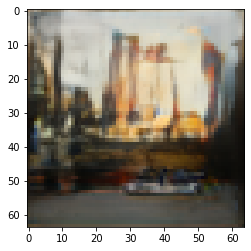

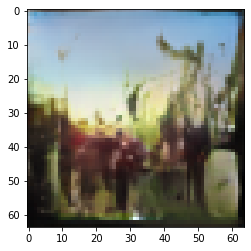

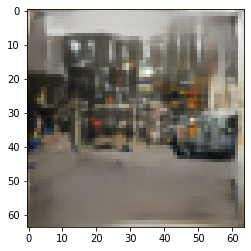

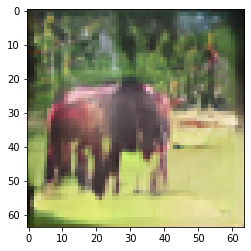

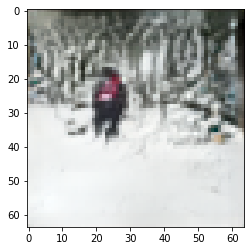

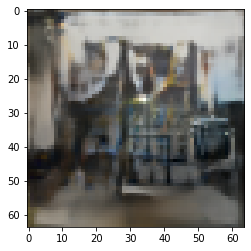

In [11]:
imgs_proc = imagenet_deprocess_batch(imgs)

for i in range(imgs_proc.shape[0]):
    img_np = imgs_proc[i].numpy().transpose(1, 2, 0)
    img_path = os.path.join('vae_images', 'img%06d.png' % i)
    imwrite(img_path, img_np)
    plt.imshow(img_np)
    plt.show()

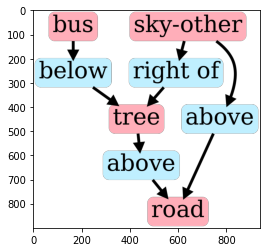

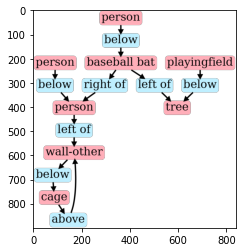

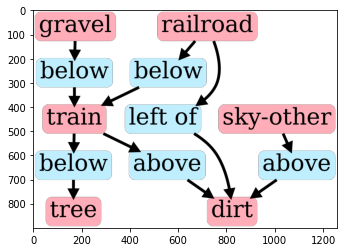

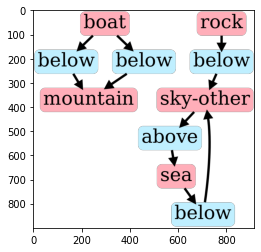

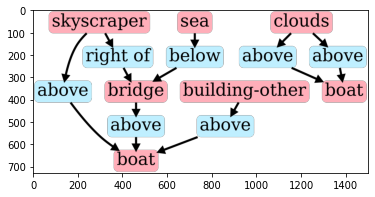

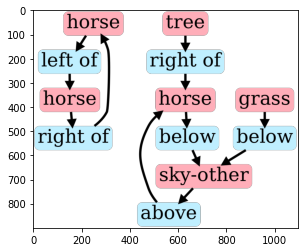

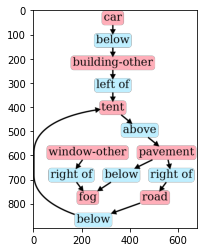

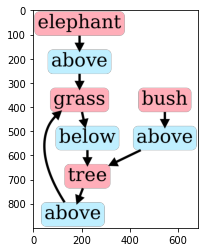

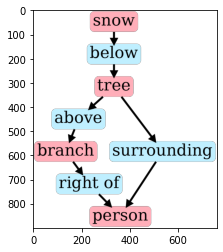

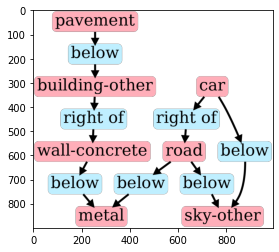

In [12]:
for i, sg in enumerate(scene_graphs):
    sg_img = vis.draw_scene_graph(sg['objects'], sg['relationships'])
    sg_img_path = os.path.join('scene_graphs', 'sg%06d.png' % i)
    imwrite(sg_img_path, sg_img)
    plt.imshow(sg_img)
    plt.show()